# Run TJPCOV with LSST Specs

TODO:
- Get the n(z) and binning of LSST from CCLX notebooks
- Get the mask of LSST
- Make the initiaiton of the sacc file
- Get the Gaussian and Namaster covariance 

Then to include CMB lensing
- Maks of CMB maps (Planck, SO and S4)
- Compute the Gaussian and the Namaster covariances

But for CMB lensing we need to include the CMB K reconstruction noise whihc depends on the experiment considered. For now I had a random constant to have teh cmbk noise in TJPCov

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sacc
import pyccl as ccl
import numpy as np
import matplotlib.pyplot as pl
import healpy as hp
import pymaster as nmt
import yaml
from tjpcov.covariance_calculator import CovarianceCalculator
import yaml

In [3]:
ccl.__version__

'3.0.0'

In [4]:
# Set this directory according to where it is on your computer
cclx_dir = '/Users/louis/code/CCLX'

In [5]:
# Import the binning recipes of LSST DESC 

import sys, os
sys.path.append(os.path.join(cclx_dir))

import srd_redshift_distributions as srd
import binning

In [6]:
# Define the redshift interval and forecast years
redshift_range = np.linspace(0.01, 3.5, 300)
forecast_years = ["1", "10"] 

# Create a dictionary to store the redshift distributions
# for each forecast year and galaxy sample
redshift_distribution = {
    "sources": {},
    "lenses": {}
}

normalised = False
for year in forecast_years:
    source_dist = srd.SRDRedshiftDistributions(redshift_range, 
                                               galaxy_sample="source_sample",
                                               forecast_year=year)
    lens_dist = srd.SRDRedshiftDistributions(redshift_range, 
                                             galaxy_sample="lens_sample",
                                             forecast_year=year)

    redshift_distribution["sources"][year] = source_dist.get_redshift_distribution(normalised=normalised,
                                                                                   save_file=False)
    redshift_distribution["lenses"][year] = lens_dist.get_redshift_distribution(normalised=normalised,
                                                                                save_file=False)

In [7]:
# Define a dictionary to store the bins
bins = {
    "sources": {},
    "lenses": {}
}
normalised = False
# Perform the binning procedure
for year in forecast_years:
    bins["sources"][year] = binning.Binning(redshift_range, 
                                            redshift_distribution["sources"][year],
                                            year).source_bins(normalised=normalised,
                                                              save_file=False)
    bins["lenses"][year] = binning.Binning(redshift_range, 
                                           redshift_distribution["lenses"][year],
                                           year).lens_bins(normalised=normalised,
                                                           save_file=False)


Text(0.5, 0, 'z')

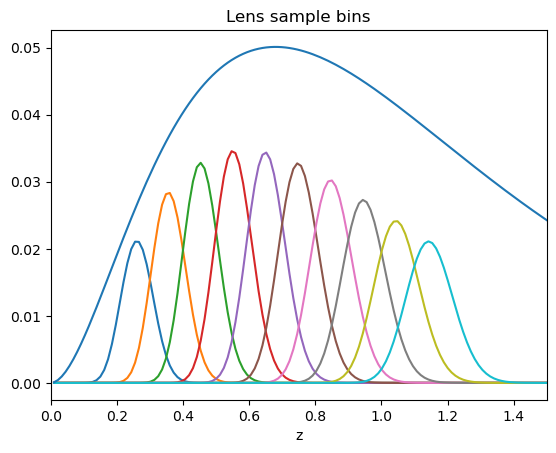

In [8]:
# plots 
year = '10' 

for bin_idx, (key, data) in enumerate(bins["lenses"][year].items()):
    pl.plot(redshift_range,
            data, 
            label=f"Bin {key+1}",)
pl.xlim(0, 1.5)

pl.plot(redshift_range, redshift_distribution["lenses"][year] )

pl.title('Lens sample bins')
pl.xlabel('z')

Text(0.5, 0, 'z')

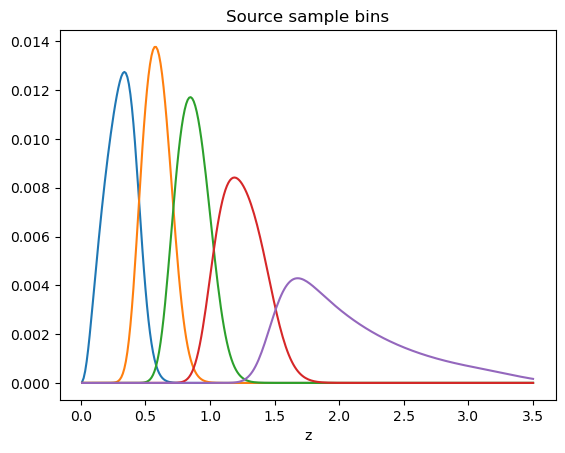

In [9]:
for bin_idx, (key, data) in enumerate(bins["sources"][year].items()):
    pl.plot(redshift_range,
            data, 
            label=f"Bin {key+1}",)
# pl.xlim(0, 1.5)


pl.title('Source sample bins')
pl.xlabel('z')

## Generate the data
We will first use CCL to generate some data. This will include all the auto- and cross-correlations between a redshift bin with galaxy clustering and cosmic shear, one CMB lensing map and I/Q/U maps in a given frequency channel.

In [10]:
# Cosmology
cosmo = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, h=0.72, n_s=0.96, A_s=2.1e-9)

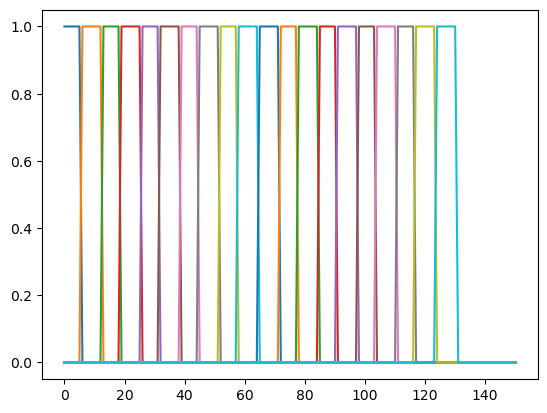

In [11]:
lmin = 20 
lmax = 150 # Becasue lmax = 3 * nside ? 
n_ell = 20 

bpw_edges = np.linspace(lmin, lmax+1, n_ell+1)
ells = np.array((bpw_edges[1:] + bpw_edges[:-1])/2, dtype='int')
d_ell = np.diff(bpw_edges)

ells_large = np.arange(lmax+1)
window_single = np.zeros([n_ell, lmax+1])
for i in range(n_ell):
    window_single[i, int(i * d_ell[i]) : int((i + 1) * d_ell[i])] = 1.

pl.figure()
for w in window_single:
    pl.plot(ells_large, w)
# pl.xlim([0,100])
pl.show()

### LSS power spectra
First we create the galaxy clustering (GC), weak lensing (WL) and CMB lensing tracers with CCL for which we will compute power spectra

In [12]:
with open(os.path.join(cclx_dir, "parameters/lsst_desc_parameters.yaml"), "r") as f:
    lsst_parameters = yaml.load(f, Loader=yaml.FullLoader)

In [13]:
# CCL tracers

forecast_year = '10' 

galaxy_bias_prefactor = lsst_parameters['lens_sample'][forecast_year]['galaxy_bias_prefactor']
# bz = 1 + redshift_range 
# Also we negelt IA for now 
bofz = lambda z :  galaxy_bias_prefactor / cosmo.growth_factor(1/(1+z))
# bias_z = galaxy_bias_prefactor / cosmo.growth_factor(1/(1+redshift_range))
bias_z = bofz(redshift_range)
gc = {}
sh = {}

for bin_idx, (key, data) in enumerate(bins["lenses"][year].items()):
    gc[bin_idx] = ccl.NumberCountsTracer(cosmo, dndz=(redshift_range, data), bias=(redshift_range, bias_z), has_rsd=True)

for bin_idx, (key, data) in enumerate(bins["sources"][year].items()):
    sh[bin_idx] = ccl.WeakLensingTracer(cosmo, dndz=(redshift_range, data), ia_bias=None)

ck = ccl.CMBLensingTracer(cosmo, z_source=1100.)




In [14]:
# Get gal density per bin

n_bar_lens = lsst_parameters['lens_sample'][year]['n_bar']
n_bar_source = lsst_parameters['source_sample'][year]['n_bar']

nbar_gc = {}
nbar_sh = {}

for bin_idx, (key, data) in enumerate(bins["lenses"][year].items()):    
    nbar_gc[bin_idx] = -np.trapz(data, redshift_range) 
norm_tot = np.sum(np.fromiter((nbar_gc[k] for k in nbar_gc.keys()), float))
for bin_idx, (key, data) in enumerate(bins["lenses"][year].items()):
    nbar_gc[bin_idx] *= n_bar_lens / norm_tot
    
for bin_idx, (key, data) in enumerate(bins["sources"][year].items()):    
    nbar_sh[bin_idx] = -np.trapz(data, redshift_range) 

norm_tot = np.sum(np.fromiter((nbar_sh[k] for k in nbar_sh.keys()), float))
for bin_idx, (key, data) in enumerate(bins["sources"][year].items()):
    nbar_sh[bin_idx] *= n_bar_source / norm_tot
 

In [15]:
nbar_sh

{0: 5.47731275713034,
 1: 5.358229897891809,
 2: 5.369935339216082,
 3: 5.388981573708484,
 4: 5.405540432053287}

In [16]:
nbar_gc

{0: 2.886465455920032,
 1: 4.0850132787952695,
 2: 4.9431256824129575,
 3: 5.4497595397327325,
 4: 5.651290371610469,
 5: 5.612857216780005,
 6: 5.39979128080799,
 7: 5.069493974851079,
 8: 4.668712017623702,
 9: 4.233491181465768}

In [17]:
# Noise power spectra
nl_gc = {}
nl_sh = {}
sigma_e = 0.26

for bin_idx, (key, data) in enumerate(bins["lenses"][year].items()):
    nl_gc[bin_idx] = np.ones(n_ell) / (nbar_gc[bin_idx] * (60 * 180 / np.pi)**2)

for bin_idx, (key, data) in enumerate(bins["sources"][year].items()):       
    nl_sh[bin_idx] = np.ones(n_ell) * sigma_e**2 / (nbar_sh[bin_idx] * (60 * 180 / np.pi)**2)


# Power spectra

[]

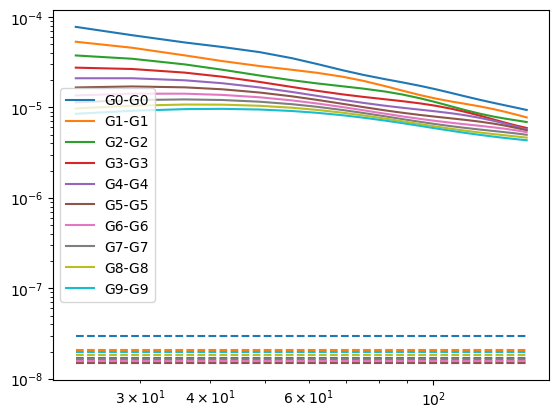

In [18]:
cls = {}

for bin_idx in bins["lenses"][year]:
#     ells_bin = np.array((bpw_edges[1:] + bpw_edges[:-1])/2, dtype='int')
    cls[f'G{bin_idx}-G{bin_idx}'] = ccl.angular_cl(cosmo, gc[bin_idx], gc[bin_idx], ells)
    p = pl.plot(ells, cls[f'G{bin_idx}-G{bin_idx}'], label=f'G{bin_idx}-G{bin_idx}')
    pl.plot(ells, nl_gc[bin_idx], ls='--', c=p[0].get_color())
pl.legend()
pl.loglog()

[]

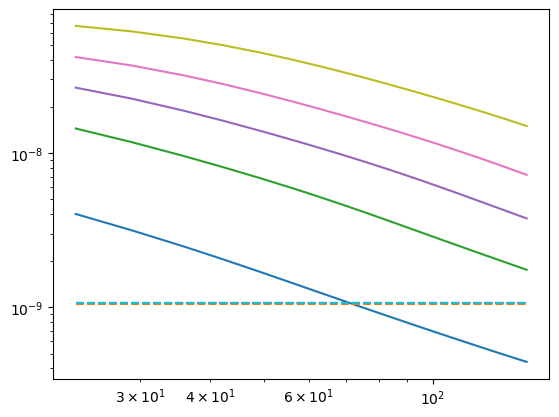

In [19]:
for bin_idx in bins["sources"][year]:
    
#     ells_bin = np.array((bpw_edges[1:] + bpw_edges[:-1])/2, dtype='int')
    cls[f'W{bin_idx}-W{bin_idx}'] = ccl.angular_cl(cosmo, sh[bin_idx], sh[bin_idx], ells)
    pl.plot(ells, cls[f'W{bin_idx}-W{bin_idx}'], label=f'W{bin_idx}-W{bin_idx}')
    pl.plot(ells, nl_sh[bin_idx], ls='--')
pl.loglog()

In [20]:
# GC x WL


In [21]:
cls['kCMB-kCMB'] = ccl.angular_cl(cosmo, ck, ck, ells)

for bin_idx in bins["lenses"][year]:
    cls[f'G{bin_idx}-kCMB']=ccl.angular_cl(cosmo, gc[bin_idx], ck, ells)

for bin_idx in bins["sources"][year]:
    cls[f'W{bin_idx}-kCMB']=ccl.angular_cl(cosmo, sh[bin_idx], ck, ells)


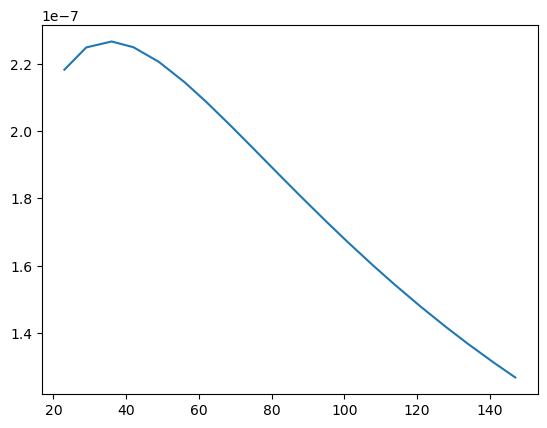

In [22]:
pl.plot(ells, cls['kCMB-kCMB'])

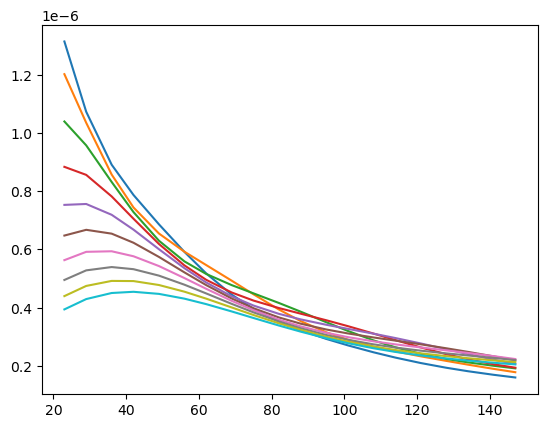

In [23]:
for bin_idx in bins["lenses"][year]:
    pl.plot(ells, cls[f'G{bin_idx}-kCMB'])

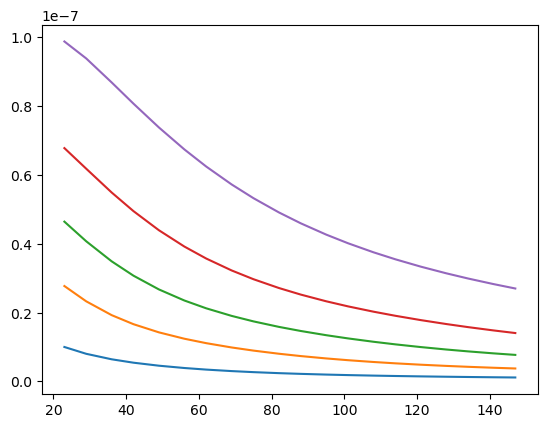

In [24]:
for bin_idx in bins["sources"][year]:
    pl.plot(ells, cls[f'W{bin_idx}-kCMB'])

# Create the SACC files

In [25]:
s = sacc.Sacc()

### Tracers
Now we add all maps as individual tracers.
The GC and WL maps will be `NZ` tracers, the CMBK tracer will be a `Map` tracer.

In [26]:
# print(sacc.standard_types)

In [27]:
# CMB lensing beam  ????
# What is it used for ??? 
# CMB lensing doesnt not have a beam, only the observed CMB from whihc it is reconstructed from has a beam

beam_fwhm = 3. # arcmin

ellmax_beam = 3000
ell_beam = np.arange(ellmax_beam+1)
beam  = hp.gauss_beam(beam_fwhm * np.pi / 60 / 180 , lmax=ellmax_beam)

In [28]:
# GC
for bin_idx in bins["lenses"][year]:
    s.add_tracer('NZ', f'gc{bin_idx}',  # Name
                 quantity='galaxy_density',  # Quantity
                 spin=0,  # Spin
                 z=redshift_range,  # z
                 nz=bins["lenses"][year][bin_idx])  # nz

# WL
for bin_idx in bins["sources"][year]:
    s.add_tracer('NZ', f'wl{bin_idx}',  # Name
                 quantity='galaxy_shear',  # Quantity
                 spin=2,  # Spin
                 z=redshift_range,  # z
                 nz=bins["lenses"][year][bin_idx])  # nz
#                  extra_columns={'error': 0.1*nz},  # You can include extra columns for the N(z)
#                  sigma_g=0.28)  # You can add any extra information as **kwargs


# CMBK
s.add_tracer('Map', 'ck',  # Name
             spin=0,  # Spin)
             quantity='cmb_convergence',
             ell=ell_beam, beam=beam)  # Beam

In [29]:
s.tracers

{'gc0': <sacc.tracers.NZTracer at 0x159e8f3d0>,
 'gc1': <sacc.tracers.NZTracer at 0x15965c4d0>,
 'gc2': <sacc.tracers.NZTracer at 0x159e46950>,
 'gc3': <sacc.tracers.NZTracer at 0x159f1cb10>,
 'gc4': <sacc.tracers.NZTracer at 0x159f1d0d0>,
 'gc5': <sacc.tracers.NZTracer at 0x159f1d790>,
 'gc6': <sacc.tracers.NZTracer at 0x159f1e190>,
 'gc7': <sacc.tracers.NZTracer at 0x159f1e690>,
 'gc8': <sacc.tracers.NZTracer at 0x159f1ecd0>,
 'gc9': <sacc.tracers.NZTracer at 0x159f1f1d0>,
 'wl0': <sacc.tracers.NZTracer at 0x159f1f4d0>,
 'wl1': <sacc.tracers.NZTracer at 0x159f1f510>,
 'wl2': <sacc.tracers.NZTracer at 0x159f1f610>,
 'wl3': <sacc.tracers.NZTracer at 0x159f1f6d0>,
 'wl4': <sacc.tracers.NZTracer at 0x159f1f7d0>,
 'ck': <sacc.tracers.MapTracer at 0x159f1f950>}

In [30]:
# Create a SACC bandpower window object
wins = sacc.BandpowerWindow(ells_large, window_single.T)


# GC 
for bin_idx in bins["lenses"][year]: 
    s.add_ell_cl('cl_00',  # Data type
                 f'gc{bin_idx}',  # 1st tracer's name
                 f'gc{bin_idx}',  # 2nd tracer's name
                 ells,  # Effective multipole
                 cls[f'G{bin_idx}-G{bin_idx}'],  # Power spectrum values
                 window=wins,  # Bandpower windows
                )
    
# WL
for bin_idx in bins["sources"][year]: 
    s.add_ell_cl('cl_ee', f'wl{bin_idx}', f'wl{bin_idx}', ells, cls[f'W{bin_idx}-W{bin_idx}'], window=wins)

# GC-WL
# s.add_ell_cl('cl_0e', 'gc', 'wl', ells, cls[0, 1, :], window=wins)
# s.add_ell_cl('cl_0b', 'gc', 'wl', ells, cls[0, 2, :], window=wins)

# KK 
s.add_ell_cl('cl_00', 'ck', 'ck', ells, cls['kCMB-kCMB'], window=wins)


In [31]:
s.get_tracer_combinations()

[('gc0', 'gc0'),
 ('gc1', 'gc1'),
 ('gc2', 'gc2'),
 ('gc3', 'gc3'),
 ('gc4', 'gc4'),
 ('gc5', 'gc5'),
 ('gc6', 'gc6'),
 ('gc7', 'gc7'),
 ('gc8', 'gc8'),
 ('gc9', 'gc9'),
 ('wl0', 'wl0'),
 ('wl1', 'wl1'),
 ('wl2', 'wl2'),
 ('wl3', 'wl3'),
 ('wl4', 'wl4'),
 ('ck', 'ck')]

In [32]:
s.save_fits("lsstbins.fits", overwrite=True)

# Create a yaml tjpcov configuration file

In [33]:
mask_lsst = hp.read_map('mask_lsst/map_for_paul.fits')

In [34]:
fsky = np.mean(mask_lsst)
print(fsky)

0.4235026041666667


In [35]:
bin_centers = binning.Binning(redshift_range, redshift_distribution["sources"][year], year).get_bin_centers()

In [36]:
fn_nl0_kcmb = 'nlkk_v3_1_0_deproj0_SENS1_fsky0p4_it_lT30-3000_lP30-5000.dat'
so_noise_dir = '/Users/louis/code/so_noise_models/LAT_lensing_noise/lensing_v3_1_1'

N0_arr = np.loadtxt(os.path.join(so_noise_dir, fn_nl0_kcmb)).T

ells_N0 = N0_arr[0]
N0_mv = N0_arr[7]

In [37]:
# pl.plot(ells_N0, N0_mv)
# pl.plot(ells, cls['kCMB-kCMB'])
# pl.loglog()

In [38]:
config_tjpcov_lsst = {}
config_tjpcov_lsst['tjpcov'] = {
  'sacc_file': 'lsstbins.fits',
  'cosmo': '/Users/louis/code/TJPCov/tests/data/cosmo_desy1.yaml',
#   'cov_type': 'FourierGaussianFsky',
  'cov_type': 'FourierGaussianNmt',
  'outdir': 'tmp/lsst/',
}

config_tjpcov_lsst['GaussianFsky'] = {'fsky': float(fsky)} 

config_tjpcov_lsst['tjpcov']['mask_file'] = {}
config_tjpcov_lsst['tjpcov']['mask_names'] = {}

# Get the number of galaxies per z bin
for bin_idx in bins["lenses"][year]:
    config_tjpcov_lsst['tjpcov'][f'Ngal_gc{bin_idx}'] = float(nbar_gc[bin_idx])
    config_tjpcov_lsst['tjpcov'][f'bias_gc{bin_idx}'] = float(bofz(bin_centers['lenses'][bin_idx]))
    config_tjpcov_lsst['tjpcov']['mask_file'][f'gc{bin_idx}'] = 'mask_lsst/map_for_paul.fits'
    config_tjpcov_lsst['tjpcov']['mask_names'][f'gc{bin_idx}'] = 'mask_lsst'

for bin_idx in bins["sources"][year]:    
    config_tjpcov_lsst['tjpcov'][f'Ngal_wl{bin_idx}'] = float(nbar_sh[bin_idx])
    config_tjpcov_lsst['tjpcov'][f'sigma_e_wl{bin_idx}'] = float(sigma_e)    
    config_tjpcov_lsst['tjpcov']['mask_file'][f'wl{bin_idx}'] = 'mask_lsst/map_for_paul.fits'
    config_tjpcov_lsst['tjpcov']['mask_names'][f'wl{bin_idx}'] = 'mask_lsst'

    
# k CMB mask 

config_tjpcov_lsst['tjpcov']['mask_file'][f'ck'] = 'mask_lsst/map_for_paul.fits'
config_tjpcov_lsst['tjpcov']['mask_names'][f'ck'] = 'mask_lsst'
config_tjpcov_lsst['tjpcov'][f'N0_kCMB']= N0_mv[:lmax+1]

In [39]:
config_tjpcov_lsst['NaMaster'] ={
      'module': 'pymaster',
      'f':{
        'n_iter': 0,
        'lmax_sht': -1},
      'b':{
        'lmax': 90,
        'nlb': 10,},
      'w':{
        'lmax_mask': -1,
        'l_toeplitz': -1,
        'l_exact': -1,
        'dl_band': -1,
        'n_iter': 3,
        'recompute': True},
      'cw':
        {'l_toeplitz': -1,
        'l_exact': -1,
        'dl_band': -1,
        'n_iter': 3,
        'recompute': True},
}

In [40]:
# fn_yaml = 'config_tjpcov_lsst.yml'
# with open(fn_yaml, 'w') as outfile:
#     yaml.dump(config_tjpcov_lsst, outfile, default_flow_style=False)


# Compute covariance matrix

In [41]:
# Sacc file generated from the CMB_LSS_write notebook 

fn_sacc = 'lsstbins.fits'
s = sacc.Sacc.load_fits(fn_sacc)
dts = s.get_data_types()
# for dt in dts:
#     print(dt)
#     tracer_sets = s.get_tracer_combinations(dt)
#     print(tracer_sets)

    
for n, t in s.tracers.items():
    print(t.name, t.quantity, type(t))
    
    
# Type of power spectra
data_types = np.unique([d.data_type for d in s.data])
print("Data types: ", data_types)

# Tracer combinations
print("Tracer combinations: ", s.get_tracer_combinations())

# Data size
print("Size: ", s.mean.size)

ck cmb_convergence <class 'sacc.tracers.MapTracer'>
gc0 galaxy_density <class 'sacc.tracers.NZTracer'>
gc1 galaxy_density <class 'sacc.tracers.NZTracer'>
gc2 galaxy_density <class 'sacc.tracers.NZTracer'>
gc3 galaxy_density <class 'sacc.tracers.NZTracer'>
gc4 galaxy_density <class 'sacc.tracers.NZTracer'>
gc5 galaxy_density <class 'sacc.tracers.NZTracer'>
gc6 galaxy_density <class 'sacc.tracers.NZTracer'>
gc7 galaxy_density <class 'sacc.tracers.NZTracer'>
gc8 galaxy_density <class 'sacc.tracers.NZTracer'>
gc9 galaxy_density <class 'sacc.tracers.NZTracer'>
wl0 galaxy_shear <class 'sacc.tracers.NZTracer'>
wl1 galaxy_shear <class 'sacc.tracers.NZTracer'>
wl2 galaxy_shear <class 'sacc.tracers.NZTracer'>
wl3 galaxy_shear <class 'sacc.tracers.NZTracer'>
wl4 galaxy_shear <class 'sacc.tracers.NZTracer'>
Data types:  ['cl_00' 'cl_ee']
Tracer combinations:  [('ck', 'ck'), ('gc0', 'gc0'), ('gc1', 'gc1'), ('gc2', 'gc2'), ('gc3', 'gc3'), ('gc4', 'gc4'), ('gc5', 'gc5'), ('gc6', 'gc6'), ('gc7', 'gc7'

In [42]:
# Useful functions from TJPCov/tests/test_covariance_fourier_gaussian_nmt.py

def get_config(fname):
    return CovarianceIO._parse(fname)

def get_nmt_bin(nside, bpw_edges, lmax=None):
    if lmax is None: 
        lmax = 3*nside
    assert lmax< 3*nside +1
    if lmax != 3 * nside:
        # lmax + 1 because the last ell is not included
        bpw_edges = bpw_edges[bpw_edges < lmax + 1]
        bpw_edges[-1] = lmax + 1

    return nmt.NmtBin.from_edges(bpw_edges[:-1], bpw_edges[1:])


In [43]:
nside = hp.get_nside(mask_lsst)

nmtbins = get_nmt_bin(nside, bpw_edges.astype('int'))
config_tjpcov_lsst["tjpcov"]["binning_info"] = nmtbins

In [44]:
# cc = CovarianceCalculator(fn_yaml)
cc = CovarianceCalculator(config_tjpcov_lsst)

In [45]:
cov = cc.get_covariance(use_coupled_noise=False)

Computing independent covariance blocks
Computing the blocks for independent workspaces
('ck', 'ck') ('ck', 'ck')


/Users/louis/Code/TJPCov/tjpcov/covariance_builder.py:892: UserWarning: Missing n_ell_coupled info for some tracers in the sacc file. You will have to pass it withthe cache
  warnings.warn(
/opt/miniconda3/envs/tjpcov0p4/lib/python3.11/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "
/Users/louis/Code/TJPCov/tjpcov/covariance_fourier_gaussian_nmt.py:253: UserWarning: Computing the coupled noise from the uncoupled noise. This assumes the noise is white
  warnings.warn(


('wl0', 'wl0') ('wl0', 'wl0')
Computing the blocks for independent covariance workspaces
('ck', 'ck') ('wl0', 'wl0')
Computing the remaining blocks
('ck', 'ck') ('gc0', 'gc0')
('ck', 'ck') ('gc1', 'gc1')
('ck', 'ck') ('gc2', 'gc2')
('ck', 'ck') ('gc3', 'gc3')
('ck', 'ck') ('gc4', 'gc4')
('ck', 'ck') ('gc5', 'gc5')
('ck', 'ck') ('gc6', 'gc6')
('ck', 'ck') ('gc7', 'gc7')
('ck', 'ck') ('gc8', 'gc8')
('ck', 'ck') ('gc9', 'gc9')
('ck', 'ck') ('wl1', 'wl1')
('ck', 'ck') ('wl2', 'wl2')
('ck', 'ck') ('wl3', 'wl3')
('ck', 'ck') ('wl4', 'wl4')
('gc0', 'gc0') ('gc0', 'gc0')
('gc0', 'gc0') ('gc1', 'gc1')
('gc0', 'gc0') ('gc2', 'gc2')
('gc0', 'gc0') ('gc3', 'gc3')
('gc0', 'gc0') ('gc4', 'gc4')
('gc0', 'gc0') ('gc5', 'gc5')
('gc0', 'gc0') ('gc6', 'gc6')
('gc0', 'gc0') ('gc7', 'gc7')
('gc0', 'gc0') ('gc8', 'gc8')
('gc0', 'gc0') ('gc9', 'gc9')
('gc0', 'gc0') ('wl0', 'wl0')
('gc0', 'gc0') ('wl1', 'wl1')
('gc0', 'gc0') ('wl2', 'wl2')
('gc0', 'gc0') ('wl3', 'wl3')
('gc0', 'gc0') ('wl4', 'wl4')
('gc1', 'g

/var/folders/k2/pz579q490y94_cj44cpv_5l80000gn/T/ipykernel_56686/2344111848.py:1: RuntimeWarning: divide by zero encountered in log10
  pl.imshow(np.log10(np.abs(cov)))


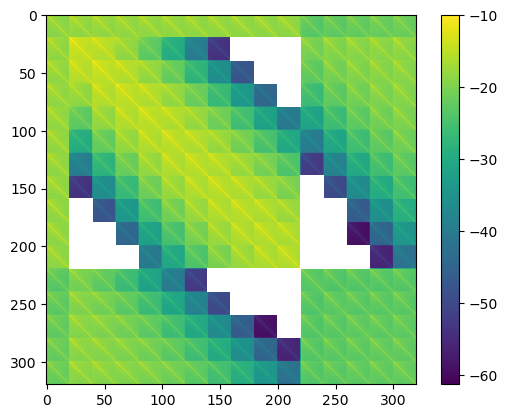

In [46]:
pl.imshow(np.log10(np.abs(cov)))
pl.colorbar()
pl.show()

In [47]:
def cov2corr(cov):
    s = np.sqrt(cov.diagonal())
    return cov/np.outer(s,s)

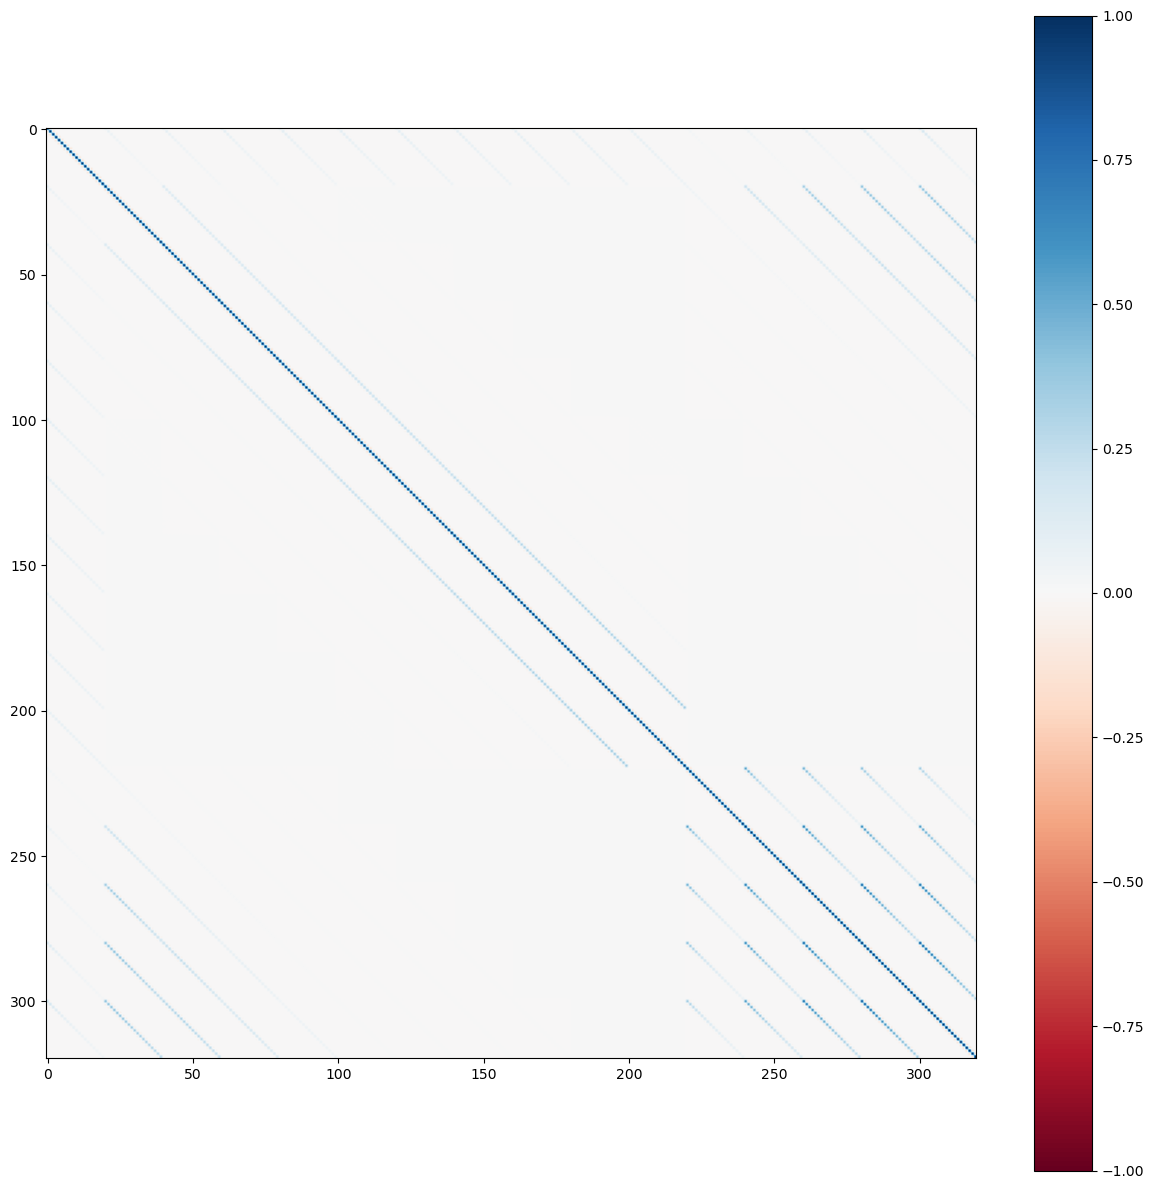

In [48]:
pl.figure(figsize=(15, 15))
pl.imshow(cov2corr(cov),vmin=-1, vmax=1, cmap='RdBu')
pl.colorbar()
pl.show()